# Setup

In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
import seaborn as sns

In [2]:
# fips code for Tableau  But we may not need because of County/state
def fips(df, inplace = True):
    if inplace:
        df["FIPS"] = df[["FIPS State Code", "FIPS County Code"]].apply(lambda row: str(row[0]) + "{:03d}".format(row[1]), axis=1)
    else:
        new_df = df.copy()
        new_df["FIPS"] = new_df[["FIPS State Code", "FIPS County Code"]].apply(lambda row: str(row[0]) + "{:03d}".format(row[1]), axis=1)
        return new_df

# Read Dataset

In [3]:
df = pd.read_csv('../data/Opioid_Seizures_and_Arrests_CY_2013_-_Current_Quarterly_County_State_Police.csv')
df.head()

,Year,Qtr,Qtr Start Date,County Code,County Code Text,FIPS State Code,FIPS County Code,County Name,Drug,Incident Count,Drug Quantity,Unit Used,Arrests,Latitude,Longitude,Georeferenced Latitude & Longitude
0,2022,Q2,04/01/2022,60,60,42,119,Union,Heroin,1,0.00660,Kilograms,1,40.964731,-77.064158,POINT (-77.064158 40.964731)
1,2022,Q3,07/01/2022,38,38,42,75,Lebanon,Heroin,1,0.00600,Kilograms,1,40.367597,-76.461826,POINT (-76.461826 40.367597)
2,2022,Q2,04/01/2022,65,65,42,129,Westmoreland,Fentanyl,4,0.20125,Kilograms,7,40.310315,-79.471341,POINT (-79.471341 40.310315)
3,2022,Q2,04/01/2022,59,59,42,117,Tioga,Heroin,4,0.07805,Kilograms,6,41.773338,-77.257881,POINT (-77.257881 41.773338)
4,2022,Q3,07/01/2022,6,6,42,11,Berks,Fentanyl,1,0.00500,Kilograms,1,40.419396,-75.930773,POINT (-75.930773 40.419396)


In [4]:
fips(df)
df.head()

,Year,Qtr,Qtr Start Date,County Code,County Code Text,FIPS State Code,FIPS County Code,County Name,Drug,Incident Count,Drug Quantity,Unit Used,Arrests,Latitude,Longitude,Georeferenced Latitude & Longitude,FIPS
0,2022,Q2,04/01/2022,60,60,42,119,Union,Heroin,1,0.00660,Kilograms,1,40.964731,-77.064158,POINT (-77.064158 40.964731),42119
1,2022,Q3,07/01/2022,38,38,42,75,Lebanon,Heroin,1,0.00600,Kilograms,1,40.367597,-76.461826,POINT (-76.461826 40.367597),42075
2,2022,Q2,04/01/2022,65,65,42,129,Westmoreland,Fentanyl,4,0.20125,Kilograms,7,40.310315,-79.471341,POINT (-79.471341 40.310315),42129
3,2022,Q2,04/01/2022,59,59,42,117,Tioga,Heroin,4,0.07805,Kilograms,6,41.773338,-77.257881,POINT (-77.257881 41.773338),42117
4,2022,Q3,07/01/2022,6,6,42,11,Berks,Fentanyl,1,0.00500,Kilograms,1,40.419396,-75.930773,POINT (-75.930773 40.419396),42011


In [5]:
df['Unit Used'].unique()

array(['Kilograms'], dtype=object)

In [6]:
df['Unit Used'].value_counts()  ## Checking to make sur eit's only measured in Kg

Kilograms    2874
Name: Unit Used, dtype: int64

# Aggregations

In [7]:
# Group by and sum 
cnt_drug_df = (df.groupby(['County Name', 'Drug'])[['Incident Count', 'Arrests', 'Drug Quantity']]
                .sum()
                .reset_index()
                .rename(columns={
                                'Incident Count' : 'Total Incidents Per County/Drug',
                                'Arrests' : 'Total Arrests Per County/Drug',
                                'Drug Quantity' : 'Total Drug Quantity Per County/Drug'
                                }))
            
cnt_df = (df.groupby('County Name')[['Incident Count', 'Arrests', 'Drug Quantity']] 
           .sum()
           .reset_index()
           .rename(columns={
                            'Incident Count' : 'Grand Total Incidents Per County',
                            'Arrests' : 'Grand Total Arrests Per County',
                            'Drug Quantity' : 'Grand Total Drug Quantity Per County'
                           }))


# Merge dataframes
final_df = pd.merge(cnt_drug_df,cnt_df, how="inner",left_on ='County Name',right_on = 'County Name')

# Need to indicate State for Tableau
final_df['State'] = 'PA'

final_df.head()

,County Name,Drug,Total Incidents Per County/Drug,Total Arrests Per County/Drug,Total Drug Quantity Per County/Drug,Grand Total Incidents Per County,Grand Total Arrests Per County,Grand Total Drug Quantity Per County,State
0,Adams,Fentanyl,18,20,0.036412,136,109,0.720047,PA
1,Adams,Heroin,117,88,0.683633,136,109,0.720047,PA
2,Adams,Opium,1,1,0.000002,136,109,0.720047,PA
3,Allegheny,Fentanyl,76,75,21.167327,646,786,43.443200,PA
4,Allegheny,Heroin,568,709,20.912073,646,786,43.443200,PA


In [8]:
# final_df.to_csv('Arestsfortableau.csv')

# Plots

<h2> We may want to just allow Tableau to group by, we can isolate by drug in the dashboard

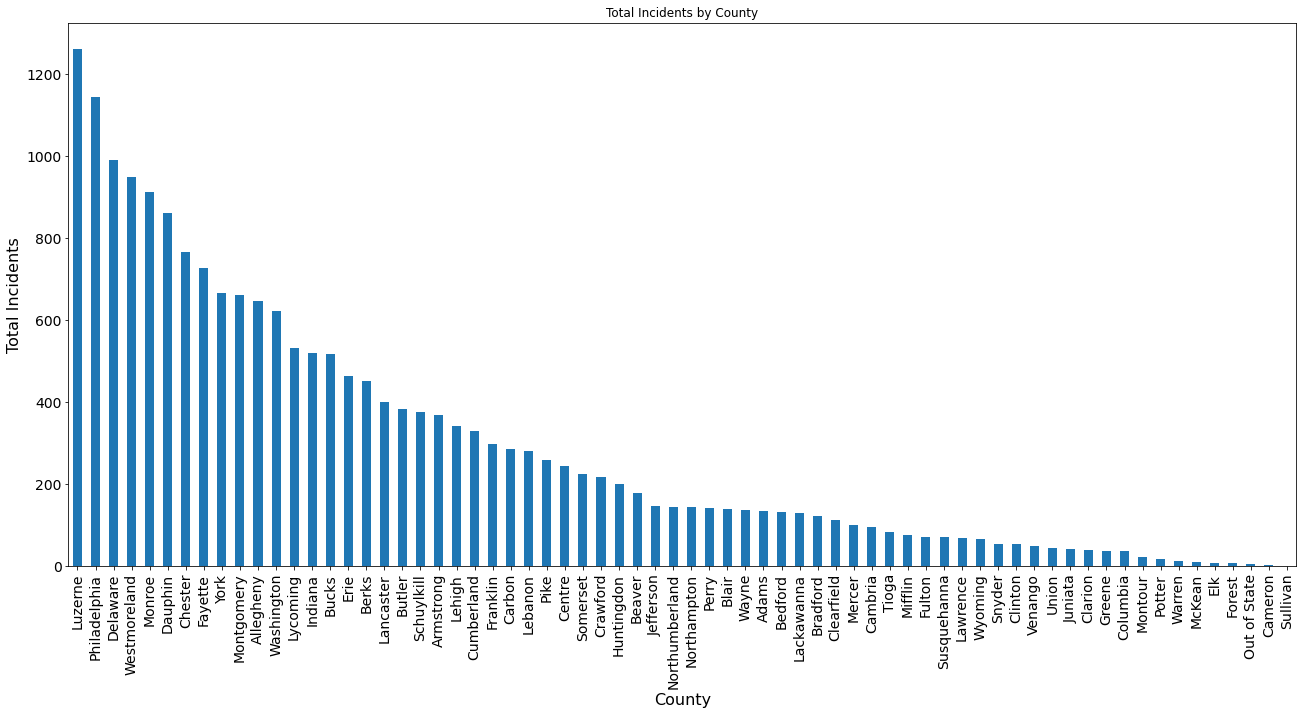

In [11]:
# Subset
small_df = final_df[["County Name", "Grand Total Incidents Per County"]].drop_duplicates()
small_df.sort_values(by=['Grand Total Incidents Per County'], inplace=True, ascending=False)

# Create x-axis labels
countindex = []
for i, row in small_df.iterrows():
    countindex.append(row['County Name'])

# Plot 
plt.rcParams["figure.figsize"] = (22,10)
small_df.groupby(['County Name'])['Grand Total Incidents Per County'].sum().reindex(countindex).plot.bar(fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(xlabel = 'County', fontsize=16)
plt.ylabel(ylabel = 'Total Incidents', fontsize=16)
plt.title('Total Incidents by County')
plt.show()

In [10]:
##May need to limit to top counties